# Model assessment basics

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
pd.options.display.float_format = '{:,.3f}'.format

def MAPE(y_true, y_pred): # favors estimates below truth
    if np.isclose(y_true,0.0).any():
        return np.nan
    return np.mean(np.abs((y_pred - y_true) / y_true))

def MMAR(y_true, y_pred): # mean max abs ratio
    y_min = np.minimum(np.abs(y_pred), np.abs(y_true)) # if either is zero, inf
    if np.isclose(y_min,0.0).any():
        return np.nan
    if (np.minimum(y_pred, y_true)<0).any():
        return np.nan
    a = np.abs(y_pred/y_true)
    b = np.abs(y_true/y_pred)
    m = np.maximum(a,b)
    return np.mean(m)

def sMAPE(y_true, y_pred):
    # check to ensure neither value is zero at same time
    y_max = np.maximum(np.abs(y_pred), np.abs(y_true))
    if np.isclose(y_max,0.0).any():
        return np.nan
    e = np.abs(y_pred - y_true)
    avg = (0.5 * (np.abs(y_pred) + np.abs(y_true)))
    return np.mean(e / avg)

## Training set metric on random data

In [2]:
X_train = np.random.random((1000,4))
y_train = np.random.random(1000)
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.8416108686339763

## NYC rent testing

In [3]:
df_rent = pd.read_json("data/rent-train.json")
features = ['bedrooms', 'bathrooms', 'latitude', 'longitude']
df_rent = df_rent[features+['price']]
X = df_rent.drop('price', axis=1)
y = df_rent['price']
X.head()

,bedrooms,bathrooms,latitude,longitude
4,1,1.000,40.711,-73.954
6,2,1.000,40.751,-73.972
9,2,1.000,40.758,-73.963
10,3,1.500,40.715,-73.942
15,0,1.000,40.744,-73.974


In [4]:
df_rent = pd.read_json("data/rent-train.json")
df_rent[['description','features']][2:4]

,description,features
9,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,"[Doorman, Elevator, Laundry in Building, Laund..."
10,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,[]


**Break out 20% hold out validation set**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

**Train model, compute metrics**

In [6]:
def test():
    rf = RandomForestRegressor(n_estimators=50, oob_score=True, n_jobs=-1)
    rf.fit(X_train, y_train)
    oob = rf.oob_score_ # wow this is a terrible score
    y_pred = rf.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return (oob,r2,mae,mse)
    df_metrics = pd.DataFrame([[oob,r2,mae,mse]],
                              columns=['OOB', 'R^2', 'MAE', 'MSE'])
    print(df_metrics)
#    print(f"{oob:4.2f}, {r2:5.2f}, {mae:5.2f}, {mse:.2f}")

**This error is stable; just variation due to RF**

In [7]:
pd.DataFrame([test() for i in range(3)], columns=['OOB', 'R^2', 'MAE', 'MSE'])

,OOB,R^2,MAE,MSE
0,-0.149,0.559,389.255,"3,624,944.824"
1,-0.132,0.559,392.311,"3,624,729.233"
2,-0.066,0.481,398.587,"4,271,988.115"


**Very unstable if we pick more valid sets**

In [8]:
results = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    results.append( test() )
df_results = pd.DataFrame(results, columns=['OOB', 'R^2', 'MAE', 'MSE'])
df_results

,OOB,R^2,MAE,MSE
0,0.006,-11.293,982.575,"1,489,007,667.048"
1,-0.243,0.481,400.620,"4,115,905.337"
2,-0.413,-1.276,766.737,"582,797,655.975"
3,-0.096,0.837,429.847,"19,675,784.139"
4,-0.339,-1.231,756.680,"525,960,734.299"


In [9]:
df_results.std()

OOB             0.172
R^2             5.011
MAE           247.375
MSE   604,012,149.621
dtype: float64

**Try k-fold**

In [10]:
k = 5
kf = KFold(n_splits=k, shuffle=True)
results = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    results.append( test() )
df_results_kfold = pd.DataFrame(results, columns=['OOB', 'R^2', 'MAE', 'MSE'])
df_results_kfold

,OOB,R^2,MAE,MSE
0,-0.247,-52.624,575.575,"362,852,224.516"
1,-0.290,-0.320,671.400,"334,872,658.788"
2,-0.162,0.494,385.504,"2,292,926.068"
3,-0.143,0.614,383.174,"2,943,516.927"
4,0.027,0.049,904.402,"2,055,986,105.459"


In [11]:
df_results_kfold.std() # still unstable; try running it multiple times

OOB             0.122
R^2            23.631
MAE           218.001
MSE   858,565,087.201
dtype: float64

In [12]:
k = 5
cvscore = cross_val_score(
			RandomForestRegressor(n_estimators=50), # which model to use
			X_train, y_train, # what training data to split up
			cv=k, # number of folds/chunks
			scoring='neg_mean_absolute_error') # what error metric
-cvscore

array([554.28698716, 381.86783002, 514.81718717, 402.86766449,
       454.92231636])

## Classifiers

In [13]:

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf = RandomForestClassifier(n_estimators=30, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

C = confusion_matrix(y_test, y_pred)
C

array([[44,  4],
       [ 1, 65]])

In [14]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).flatten()
tn, fp, fn, tp

(44, 4, 1, 65)

In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95        48
           1       0.94      0.98      0.96        66

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



## R^2

Text(0.5, 1.0, '$R^2$ = 0.987')

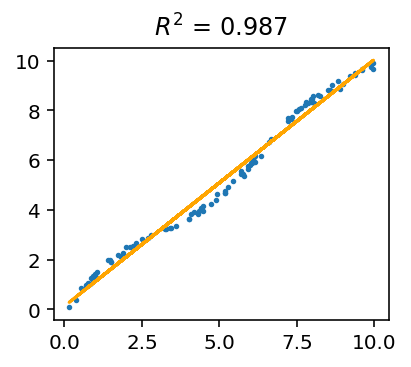

In [16]:
n = 100
x = np.random.random(size=n)*10
y = x + np.sin(x)*.45 + np.random.normal(size=n)*.1
plt.figure(figsize=(3,2.5))
plt.scatter(x,y,s=3)

lm = LinearRegression()
lm.fit(x.reshape(-1,1), y)
y_pred = lm.predict(x.reshape(-1,1))
plt.plot(x, y_pred, c='orange')
plt.title(f"$R^2$ = {lm.score(x.reshape(-1,1),y):.3f}", fontsize=12)

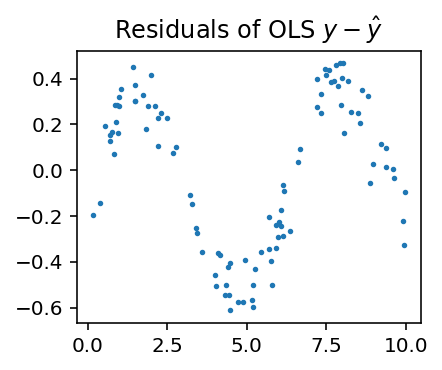

In [17]:
plt.figure(figsize=(3.08,2.5))
plt.scatter(x, y-y_pred, s=3)
plt.title("Residuals of OLS $y - \hat{y}$")
plt.show()

In [18]:
n = 10
df = pd.DataFrame()
df['x'] = np.linspace(0,10,num=n)
df['y'] = df['x'] + np.random.normal(0,1,size=n)
df

,x,y
0,0.000,-0.777
1,1.111,2.742
2,2.222,2.149
3,3.333,1.719
4,4.444,4.665
5,5.556,3.312
6,6.667,6.491
7,7.778,7.599
8,8.889,9.620
9,10.000,10.797


## MAE,MSE

In [19]:
n = 10
df = pd.DataFrame()
df['x'] = np.linspace(0,10,num=n)
df['y'] = df['x'] + np.random.normal(0,1,size=n)

X, y = df.drop('y',axis=1), df['y']
lm = LinearRegression()
lm.fit(X, y)
beta0 = lm.intercept_
beta1 = lm.coef_[0]
lm.score(X, y)

0.8888816057651303

Text(0.5, 1.0, 'MAE 0.80, MSE 0.95,\nMAPE($y,\\hat{y}$) 0.26, MAPE($\\hat{y}, y$) 0.36')

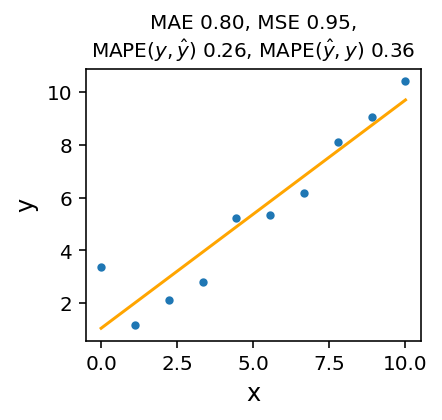

In [20]:
plt.figure(figsize=(3,2.5))
plt.scatter(df['x'], df['y'], s=10)
plt.plot(df['x'], df['x']*lm.coef_[0] + lm.intercept_, c='orange')
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
y_pred = lm.predict(X)
plt.title(f"MAE {mean_absolute_error(y,y_pred):.2f}, MSE {mean_squared_error(y,y_pred):.2f},\nMAPE($y,\hat{{y}}$) {MAPE(y,y_pred):.2f}, MAPE($\hat{{y}}, y$) {MAPE(y_pred,y):.2f}", fontsize=10)
#plt.title(f"$R^2$ = {lm.score(X,y):.3f}", fontsize=12)

In [21]:
y.iloc[-1] = 100

Text(0, 0.5, 'y')

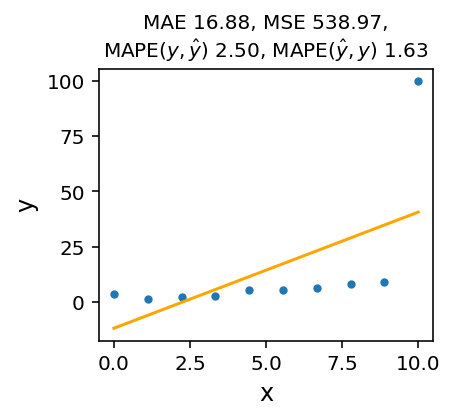

In [22]:
plt.figure(figsize=(3,2.5))

X, y = df.drop('y',axis=1), df['y']
lm = LinearRegression()
lm.fit(X, y)
beta0 = lm.intercept_
beta1 = lm.coef_[0]
lm.score(X, y)
y_pred = lm.predict(X)
plt.title(f"MAE {mean_absolute_error(y,y_pred):.2f}, MSE {mean_squared_error(y,y_pred):.2f},\nMAPE($y,\hat{{y}}$) {MAPE(y,y_pred):.2f}, MAPE($\hat{{y}}, y$) {MAPE(y_pred,y):.2f}", fontsize=10)

plt.scatter(df['x'], df['y'], s=10)
plt.plot(df['x'], df['x']*lm.coef_[0] + lm.intercept_, c='orange')
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
#plt.title(f"$R^2$ = {lm.score(X,y):.3f}", fontsize=12)

Text(0, 0.5, 'y')

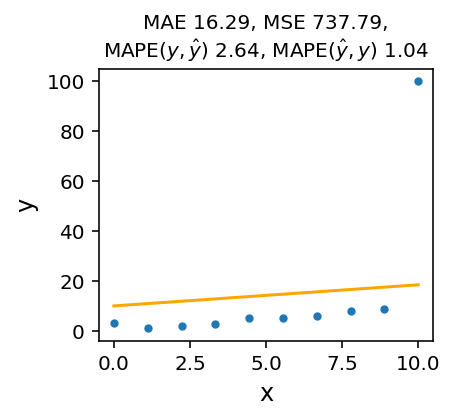

In [23]:
plt.figure(figsize=(3,2.5))

X, y = df.drop('y',axis=1), df['y']
lm = Lasso(alpha=45)
lm.fit(X, y)
beta0 = lm.intercept_
beta1 = lm.coef_[0]
lm.score(X, y)
y_pred = lm.predict(X)
plt.title(f"MAE {mean_absolute_error(y,y_pred):.2f}, MSE {mean_squared_error(y,y_pred):.2f},\nMAPE($y,\hat{{y}}$) {MAPE(y,y_pred):.2f}, MAPE($\hat{{y}}, y$) {MAPE(y_pred,y):.2f}", fontsize=10)

plt.scatter(df['x'], df['y'], s=10)
plt.plot(df['x'], df['x']*lm.coef_[0] + lm.intercept_, c='orange')
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
#plt.title(f"$R^2$ = {lm.score(X,y):.3f}", fontsize=12)

## R^2

In [24]:
n = 10
df = pd.DataFrame()
df['x'] = np.linspace(0,10,num=n)
df['y'] = df['x'] + np.random.normal(0,1,size=n)

X, y = df.drop('y',axis=1), df['y']
lm = LinearRegression()
lm.fit(X, y)
beta0 = lm.intercept_
beta1 = lm.coef_[0]
lm.score(X, y)

0.9668001973838279

Text(0.5, 1.0, '$R^2$ = 0.967')

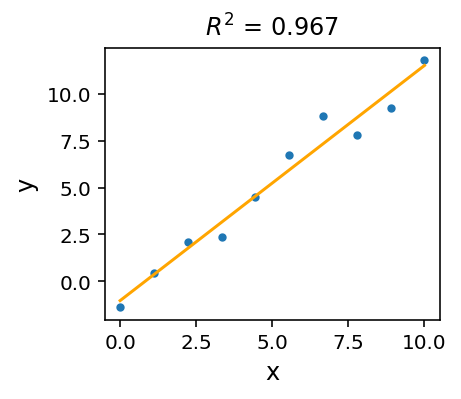

In [25]:
plt.figure(figsize=(3,2.5))
plt.scatter(df['x'], df['y'], s=10)
plt.plot(df['x'], df['x']*lm.coef_[0] + lm.intercept_, c='orange')
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
y_pred = lm.predict(X)
plt.title(f"$R^2$ = {lm.score(X,y):.3f}", fontsize=12)

In [26]:
y.iloc[-1] = 100

Text(0.5, 1.0, '$R^2$ = 0.382')

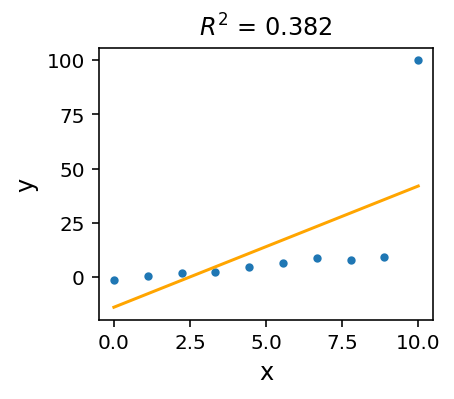

In [27]:
plt.figure(figsize=(3,2.5))

X, y = df.drop('y',axis=1), df['y']
lm = LinearRegression()
lm.fit(X, y)
beta0 = lm.intercept_
beta1 = lm.coef_[0]
lm.score(X, y)
y_pred = lm.predict(X)

plt.scatter(df['x'], df['y'], s=10)
plt.plot(df['x'], df['x']*lm.coef_[0] + lm.intercept_, c='orange')
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.title(f"$R^2$ = {lm.score(X,y):.3f}", fontsize=12)

Text(0.5, 1.0, '$R^2$ = 0.143')

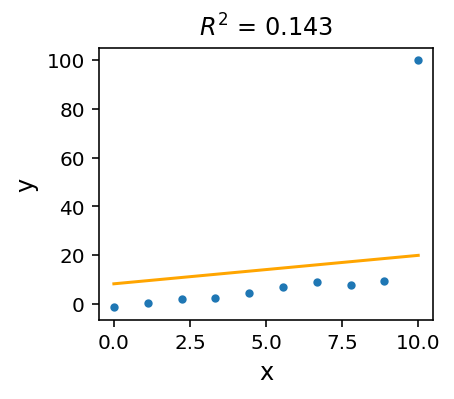

In [28]:
plt.figure(figsize=(3,2.5))

X, y = df.drop('y',axis=1), df['y']
lm = Lasso(alpha=45)
lm.fit(X, y)
beta0 = lm.intercept_
beta1 = lm.coef_[0]
lm.score(X, y)
y_pred = lm.predict(X)

plt.scatter(df['x'], df['y'], s=10)
plt.plot(df['x'], df['x']*lm.coef_[0] + lm.intercept_, c='orange')
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.title(f"$R^2$ = {lm.score(X,y):.3f}", fontsize=12)

## sMAPE

In [29]:
n = 10
df = pd.DataFrame()
df['x'] = np.linspace(0,10,num=n)
df['y'] = df['x'] + np.random.normal(0,1,size=n)

X, y = df.drop('y',axis=1), df['y']
lm = LinearRegression()
lm.fit(X, y)
beta0 = lm.intercept_
beta1 = lm.coef_[0]
lm.score(X, y)

0.9350380307475594

Text(0.5, 1.0, 'sMAPE 0.26')

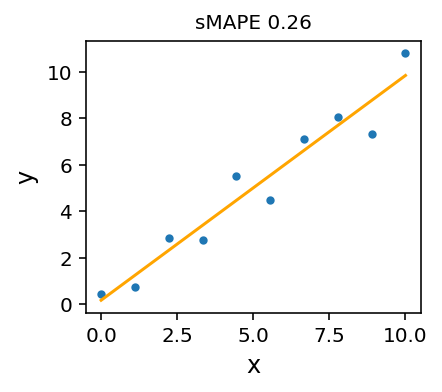

In [30]:
plt.figure(figsize=(3,2.5))
plt.scatter(df['x'], df['y'], s=10)
plt.plot(df['x'], df['x']*lm.coef_[0] + lm.intercept_, c='orange')
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
y_pred = lm.predict(X)
plt.title(f"sMAPE {sMAPE(y,y_pred):.2f}", fontsize=10)

In [31]:
y.iloc[-1] = 100

Text(0, 0.5, 'y')

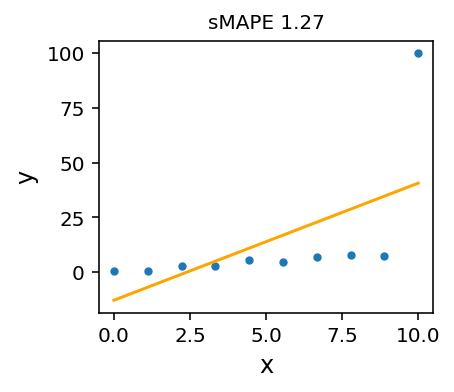

In [32]:
plt.figure(figsize=(3,2.5))

X, y = df.drop('y',axis=1), df['y']
lm = LinearRegression()
lm.fit(X, y)
beta0 = lm.intercept_
beta1 = lm.coef_[0]
lm.score(X, y)
y_pred = lm.predict(X)
plt.title(f"sMAPE {sMAPE(y,y_pred):.2f}", fontsize=10)
plt.scatter(df['x'], df['y'], s=10)
plt.plot(df['x'], df['x']*lm.coef_[0] + lm.intercept_, c='orange')
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
#plt.title(f"$R^2$ = {lm.score(X,y):.3f}", fontsize=12)

Text(0, 0.5, 'y')

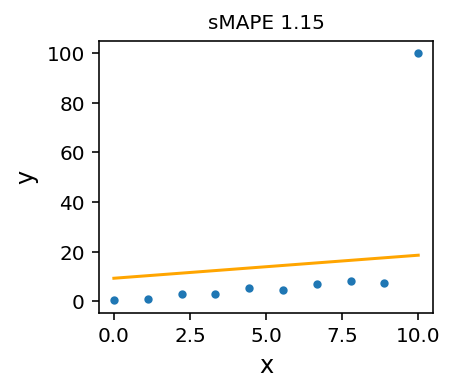

In [33]:
plt.figure(figsize=(3,2.5))

X, y = df.drop('y',axis=1), df['y']
lm = Lasso(alpha=45)
lm.fit(X, y)
beta0 = lm.intercept_
beta1 = lm.coef_[0]
lm.score(X, y)
y_pred = lm.predict(X)
plt.title(f"sMAPE {sMAPE(y,y_pred):.2f}", fontsize=10)
plt.scatter(df['x'], df['y'], s=10)
plt.plot(df['x'], df['x']*lm.coef_[0] + lm.intercept_, c='orange')
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
#plt.title(f"$R^2$ = {lm.score(X,y):.3f}", fontsize=12)